In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import load_img, img_to_array
from keras.callbacks import EarlyStopping
from keras.applications import MobileNetV2

import matplotlib.pyplot as plt

# Завантаження даних

Використаємо image_dataset_from_directory, який автоматично:
- читає картинки;
- присвоює мітки на основі назв папок;
- масштабує картинки;
- створює tf.data.Dataset для тренування.

In [2]:
image_size = (256, 256)
batch_size = 32
data_dir = '../../classification/animal/data/'

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    labels="inferred",
    label_mode="int",
    class_names=['cats', 'dogs', 'snakes'],
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=1
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    labels="inferred",
    label_mode="int",
    class_names=['cats', 'dogs', 'snakes'],
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=1
)


Found 3000 files belonging to 3 classes.
Using 2400 files for training.
Found 3000 files belonging to 3 classes.
Using 600 files for validation.


2025-05-17 17:23:33.467666: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-05-17 17:23:33.467704: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-17 17:23:33.467708: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-17 17:23:33.468064: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-17 17:23:33.468084: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
# AUTOTUNE = tf.data.AUTOTUNE
# train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [5]:
X_train, y_train = [], []
for images, labels in train_ds:
    X_train.append(images.numpy())
    y_train.append(labels.numpy())

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

X_val, y_val = [], []
for images, labels in val_ds:
    X_val.append(images.numpy())
    y_val.append(labels.numpy())

X_val = np.concatenate(X_val)
y_val = np.concatenate(y_val)


2025-05-17 17:23:34.457457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-17 17:23:35.243948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)

X_train: (2400, 256, 256, 3)
y_train: (2400,)
X_val: (600, 256, 256, 3)
y_val: (600,)


In [7]:
train_ds.class_names

['cats', 'dogs', 'snakes']

In [8]:
for images, labels in train_ds.take(1):
    print("Форма images:", images.shape)
    print("Форма labels:", labels.shape)

Форма images: (32, 256, 256, 3)
Форма labels: (32,)


2025-05-17 17:23:35.339445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<!-- https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take -->

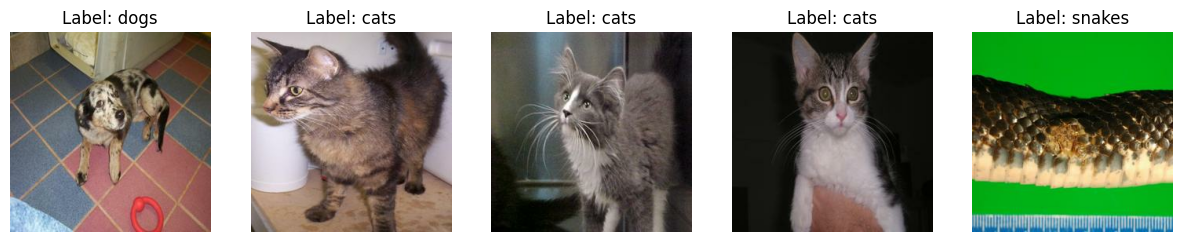

2025-05-17 17:23:35.642870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    
    for i in range(5):
        axes[i].imshow(images[i].numpy().astype("uint8"))
        axes[i].set_title(f"Label: {train_ds.class_names[labels[i].numpy()]}")
        axes[i].axis("off")

    plt.show()  


In [10]:
def show_batch(dataset, class_names, n=5):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(n * 3, 3))
        for i in range(n):
            ax = plt.subplot(1, n, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label = class_names[labels[i]]
            plt.title(label)
            plt.axis("off")
        plt.tight_layout()
        plt.show()

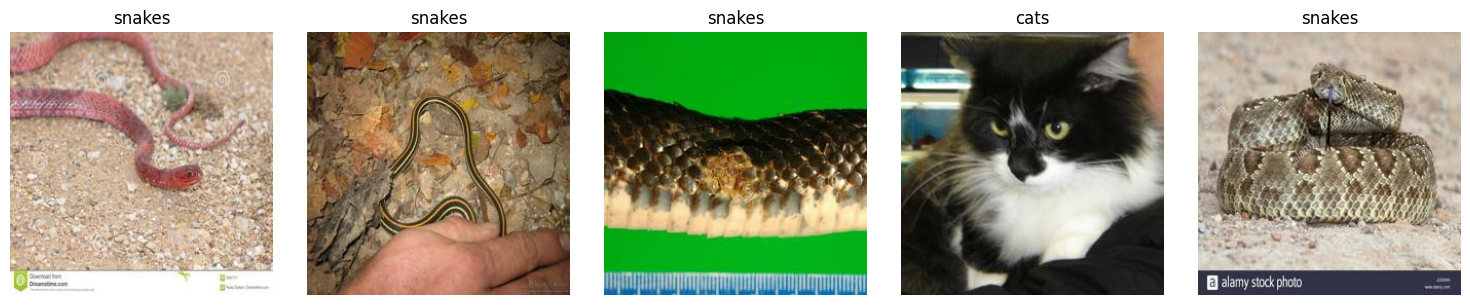

2025-05-17 17:23:35.899818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
show_batch(train_ds, train_ds.class_names, n=5)

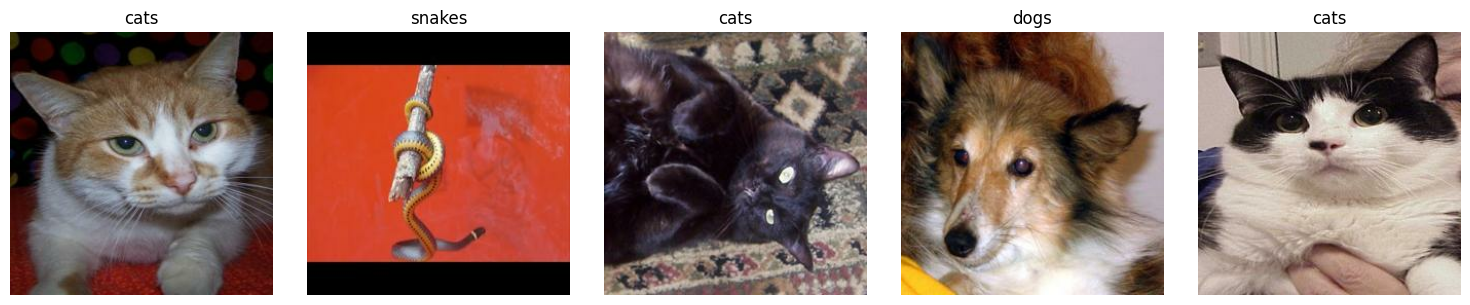

2025-05-17 17:23:36.068387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
show_batch(val_ds, val_ds.class_names, n=5)

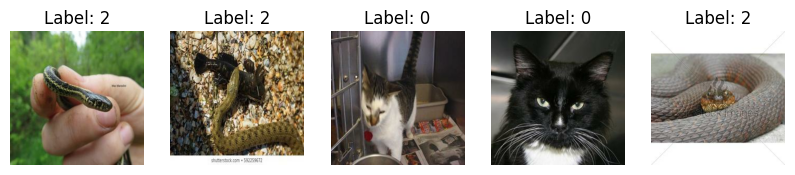

2025-05-17 17:23:36.206556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 5))
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()


# Попередня обробка

TensorFlow автоматично читає зображення у форматі (batch_size, 224, 224, 3) — це 4D тензор. Пікселі — в діапазоні [0, 255], але моделі краще працюють із нормалізованими значеннями. 

In [14]:
X_train = X_train / 255.0

X_val = X_val / 255.0

In [15]:
X_train

array([[[[0.6313726 , 0.52156866, 0.7137255 ],
         [0.6117647 , 0.5019608 , 0.69411767],
         [0.6039216 , 0.5019608 , 0.6862745 ],
         ...,
         [0.09803922, 0.09411765, 0.07843138],
         [0.11372549, 0.09803922, 0.08627451],
         [0.10196079, 0.08627451, 0.07450981]],

        [[0.6392157 , 0.5294118 , 0.72156864],
         [0.63529414, 0.5254902 , 0.7137255 ],
         [0.63529414, 0.53333336, 0.7176471 ],
         ...,
         [0.10980392, 0.10588235, 0.09019608],
         [0.10980392, 0.09411765, 0.08235294],
         [0.07843138, 0.0627451 , 0.05098039]],

        [[0.6392157 , 0.5294118 , 0.7176471 ],
         [0.65882355, 0.54901963, 0.7372549 ],
         [0.6627451 , 0.56078434, 0.74509805],
         ...,
         [0.14117648, 0.1254902 , 0.11372549],
         [0.11372549, 0.09803922, 0.08627451],
         [0.07450981, 0.05882353, 0.04705882]],

        ...,

        [[0.5019608 , 0.40392157, 0.5686275 ],
         [0.42352942, 0.3254902 , 0.47843137]

In [16]:
X_val

array([[[[0.09803922, 0.14117648, 0.08627451],
         [0.10588235, 0.14901961, 0.08627451],
         [0.11372549, 0.14509805, 0.08627451],
         ...,
         [0.6627451 , 0.7176471 , 0.7176471 ],
         [0.6627451 , 0.7176471 , 0.7176471 ],
         [0.6666667 , 0.72156864, 0.72156864]],

        [[0.1254902 , 0.16862746, 0.11372549],
         [0.14117648, 0.18431373, 0.12156863],
         [0.14117648, 0.1764706 , 0.10980392],
         ...,
         [0.6666667 , 0.7137255 , 0.7058824 ],
         [0.6666667 , 0.7137255 , 0.7058824 ],
         [0.6666667 , 0.7137255 , 0.7058824 ]],

        [[0.19607843, 0.23921569, 0.1764706 ],
         [0.22745098, 0.27058825, 0.20392157],
         [0.22745098, 0.27450982, 0.19607843],
         ...,
         [0.6784314 , 0.7137255 , 0.7019608 ],
         [0.6666667 , 0.70980394, 0.69411767],
         [0.6627451 , 0.7058824 , 0.6901961 ]],

        ...,

        [[0.7529412 , 0.64705884, 0.57254905],
         [0.74509805, 0.6392157 , 0.5647059 ]

# Побудова моделі

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(256, 256, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dense(3, activation='softmax')
    tf.keras.layers.Dense(3)

])

/Users/mariiasv/Documents/Project/junior-ds-prep/.venv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Компіляція та тренування

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [20]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),  
    epochs=30,
    callbacks=[early_stop]

)

Epoch 1/30


2025-05-17 17:23:41.515011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.3278 - loss: 239.4721 - val_accuracy: 0.3650 - val_loss: 22.8503
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.4095 - loss: 16.2767 - val_accuracy: 0.3950 - val_loss: 10.7904
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.3736 - loss: 14.6943 - val_accuracy: 0.3983 - val_loss: 9.0487
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.4131 - loss: 12.5975 - val_accuracy: 0.3950 - val_loss: 8.7782
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.3917 - loss: 12.9583 - val_accuracy: 0.4367 - val_loss: 9.0500
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.4388 - loss: 8.7279 - val_accuracy: 0.4117 - val_loss: 12.9316
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.4421 - loss: 10.2780 - val_accuracy: 0.4400 - val_loss: 6.6915
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.4491 - loss: 7.3492 - val_accura

In [21]:
results = model.evaluate(X_val, y_val, verbose=2)
print("Результати:", results)  

loss, accuracy = results
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

19/19 - 2s - 88ms/step - accuracy: 0.4400 - loss: 6.6915
Результати: [6.691540718078613, 0.4399999976158142]
Loss: 6.6915
Accuracy: 0.4400


In [22]:
print("Generate predictions for 3 samples")
predictions = model.predict(X_val[:3])
print("predictions shape:", predictions.shape)

Generate predictions for 3 samples
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
predictions shape: (3, 3)


In [23]:
probabilities = tf.nn.softmax(predictions)
print(probabilities.numpy())

[[1.1273021e-06 8.9871830e-01 1.0128058e-01]
 [1.0000000e+00 1.5100093e-11 7.5021788e-17]
 [8.5194105e-01 1.3086487e-01 1.7194044e-02]]


In [24]:
predicted_classes = tf.argmax(predictions, axis=1)
print(predicted_classes.numpy())

[1 0 0]


In [25]:
predicted_labels = [train_ds.class_names[i] for i in predicted_classes.numpy()]
print(predicted_labels)


['dogs', 'cats', 'cats']


In [26]:
predicted_labels = [val_ds.class_names[i] for i in predicted_classes.numpy()]
print(predicted_labels)


['dogs', 'cats', 'cats']


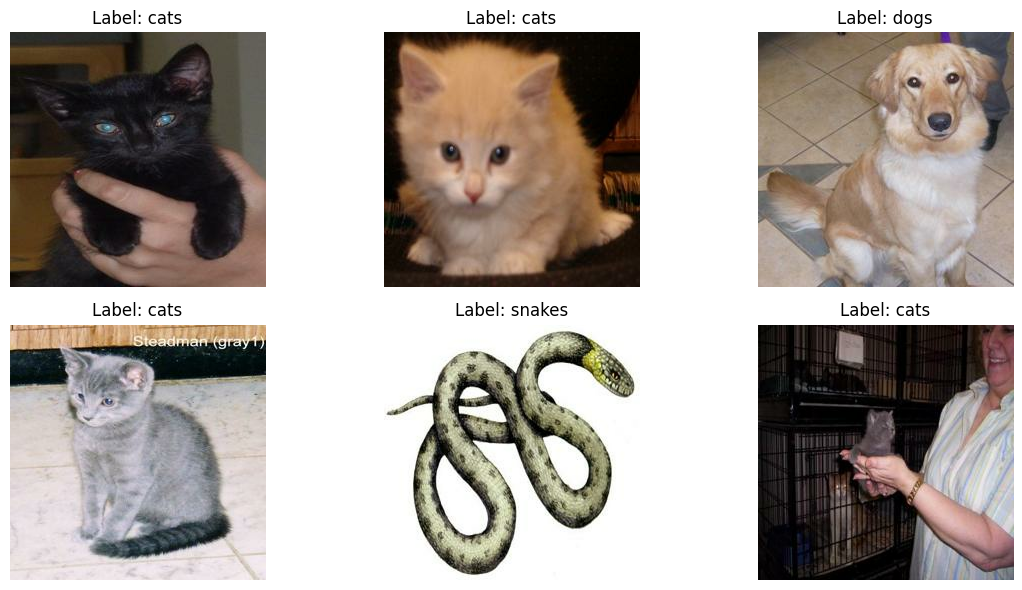

2025-05-17 17:25:40.908911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [27]:
import matplotlib.pyplot as plt


for images, labels in val_ds.take(1):
    plt.figure(figsize=(12, 6))  

    for i in range(6): 
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_idx = labels[i].numpy()
        plt.title(f"Label: {val_ds.class_names[label_idx]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [28]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),  
    epochs=30,
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/30
75/75 - 10s - 137ms/step - accuracy: 0.4200 - loss: 10.2413 - val_accuracy: 0.3967 - val_loss: 9.3011
Epoch 2/30
75/75 - 9s - 123ms/step - accuracy: 0.4567 - loss: 8.2685 - val_accuracy: 0.3750 - val_loss: 10.5789
Epoch 3/30
75/75 - 9s - 124ms/step - accuracy: 0.4246 - loss: 8.9187 - val_accuracy: 0.4100 - val_loss: 7.4289
Epoch 4/30
75/75 - 9s - 126ms/step - accuracy: 0.4067 - loss: 11.6128 - val_accuracy: 0.3883 - val_loss: 15.8667
Epoch 5/30
75/75 - 9s - 125ms/step - accuracy: 0.4258 - loss: 10.6523 - val_accuracy: 0.3717 - val_loss: 26.0863
Epoch 6/30
75/75 - 9s - 123ms/step - accuracy: 0.4300 - loss: 12.0246 - val_accuracy: 0.3583 - val_loss: 15.4838
Epoch 7/30
75/75 - 10s - 127ms/step - accuracy: 0.4483 - loss: 8.6451 - val_accuracy: 0.4183 - val_loss: 7.1009
Epoch 8/30
75/75 - 9s - 123ms/step - accuracy: 0.4513 - loss: 7.3282 - val_accuracy: 0.4083 - val_loss: 7.8939
Epoch 9/30
75/75 - 9s - 126ms/step - accuracy: 0.4342 - loss: 10.1186 - val_accuracy: 0.4000 - val_los

In [29]:
results = model.evaluate(X_val, y_val, verbose=2)
print("Результати:", results)  

loss, accuracy = results
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

19/19 - 2s - 84ms/step - accuracy: 0.4083 - loss: 7.0940
Результати: [7.093979835510254, 0.40833333134651184]
Loss: 7.0940
Accuracy: 0.4083


In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(256, 256, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3)
])


/Users/mariiasv/Documents/Project/junior-ds-prep/.venv/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 239ms/step - accuracy: 0.3835 - loss: 6.4441 - val_accuracy: 0.6000 - val_loss: 0.8327
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 236ms/step - accuracy: 0.6581 - loss: 0.7842 - val_accuracy: 0.6000 - val_loss: 0.8426
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 238ms/step - accuracy: 0.7801 - loss: 0.5161 - val_accuracy: 0.6133 - val_loss: 0.9433
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 236ms/step - accuracy: 0.9046 - loss: 0.2849 - val_accuracy: 0.6483 - val_loss: 1.0692
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 235ms/step - accuracy: 0.9540 - loss: 0.1602 - val_accuracy: 0.6117 - val_loss: 1.7470
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 242ms/step - accuracy: 0.9597 - loss: 0.1113 - val_accuracy: 0.6100 - val_loss: 1.4463


In [33]:
results = model.evaluate(X_val, y_val, verbose=2)
print("Результати:", results)  

loss, accuracy = results
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

19/19 - 2s - 125ms/step - accuracy: 0.3550 - loss: 1.9261
Результати: [1.9260860681533813, 0.35500001907348633]
Loss: 1.9261
Accuracy: 0.3550


In [34]:
# checkpoint = tf.keras.callbacks.ModelCheckpoint(
#     'best_model.h5', save_best_only=True, monitor='val_loss'
# )

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    # callbacks=[early_stop, checkpoint]
    callbacks=[early_stop]

)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 240ms/step - accuracy: 0.6246 - loss: 0.8213 - val_accuracy: 0.6283 - val_loss: 0.7881
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 239ms/step - accuracy: 0.7120 - loss: 0.6180 - val_accuracy: 0.6133 - val_loss: 0.9261
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 237ms/step - accuracy: 0.8194 - loss: 0.4666 - val_accuracy: 0.6283 - val_loss: 0.8611
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 236ms/step - accuracy: 0.8982 - loss: 0.2712 - val_accuracy: 0.6100 - val_loss: 1.2336
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 242ms/step - accuracy: 0.9408 - loss: 0.2030 - val_accuracy: 0.5650 - val_loss: 1.6427
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 236ms/step - accuracy: 0.9442 - loss: 0.1939 - val_accuracy: 0.6050 - val_loss: 1.6200


#  Інференс на нових зображеннях